# Imports

In [2]:
import pandas as pd
import numpy as np

# import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# from numpy.random import normal, uniform
# import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVR

import dill
import datetime

In [4]:
%matplotlib inline

In [3]:
dill.load_session('Full_SVR.db')

FileNotFoundError: [Errno 2] No such file or directory: 'Full_SVR.db'

In [5]:
SEED = 73 # random seed

# Data reading 

In [6]:
data = pd.read_csv('data/prepared/data_processed.csv')

In [7]:
names = data.columns
names

Index(['AP1', 'FD', 'FTa1', 'FTa2', 'FTa3', 'FTb', 'FTc', 'LFY', 'TFL1a',
       'TFL1c'],
      dtype='object')

In [8]:
gs = {} # dict of GS-tuned models

In [9]:
st_scalers = {}

In [23]:
def logging(description, out):
    string = str(description) + ': ' + str(out)
    with open('results/SVR_log.txt', 'a') as out_file:
        out_file.write(string + '\n')
    print(string)

In [11]:
logging('Running datetime', str(datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S')))

Running datetime: 24-08-2019 00:46:10



# Everything below should be in cycle !!!!

In [12]:
current_target = names[0]
current_target

'AP1'

In [13]:
# for name in names:
#     current_target = name
    

In [14]:
logging('target', current_target)

target: AP1



In [15]:
# Choose target and standartize the data

y = data[current_target]
X = data.drop(current_target, axis=1)

In [16]:
st_scalers[current_target] = StandardScaler()

In [17]:
X_st = st_scalers[current_target].fit_transform(X)

In [18]:
# train-test split

X_st_train, X_st_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.25, random_state=SEED, shuffle=True)

# SVR model

## Model building

In [86]:
svm_reg = SVR(kernel='rbf', epsilon=1)



## Rough grid search

In [87]:
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

grid = {
    'gamma': np.geomspace(0.0001, 10, 6),
    'C': np.geomspace(0.0001, 1000, 8)
    #'epsilon': np.geomspace(0.0001, 10, 6)
}

gs[current_target] = GridSearchCV(svm_reg, grid, 
                  n_jobs=-1, 
                  scoring=['neg_mean_squared_error', 'r2'], 
                  refit='neg_mean_squared_error', 
                  cv=cv, 
                  verbose=10)

In [88]:
%%time
gs[current_target].fit(X_st_train, y_train);

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0768s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:    5.9s


Wall time: 8.09 s


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:    7.9s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=73, shuffle=True),
       error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'gamma': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]), 'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
       pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
       return_train_score='warn', scoring=['neg_mean_squared_error', 'r2'],
       verbose=10)

In [89]:
logging('Rough tuning', str(gs[current_target].best_params_))    

Rough tuning: {'C': 1000.0, 'gamma': 0.0001}


In [90]:
gamma, C = gs[current_target].best_params_['gamma'], gs[current_target].best_params_['C']

## Fine tuning

In [99]:
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

grid = {
    'gamma': np.geomspace(gamma/5, gamma*5, 10),
    'C': np.geomspace(C/5, C*5, 10)
    #'epsilon': np.geomspace(epsilon/5, epsilon*5, 10)
}

gs[current_target] = GridSearchCV(svm_reg, grid, 
                  n_jobs=-1, 
                  scoring=['neg_mean_squared_error', 'r2'], 
                  refit='neg_mean_squared_error', 
                  cv=cv, 
                  verbose=10)

In [100]:
%%time
gs[current_target].fit(X_st_train, y_train);

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1326s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 172 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 266 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 300 tas

Wall time: 18.1 s


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   17.9s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=73, shuffle=True),
       error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'gamma': array([2.00000e-05, 2.85994e-05, 4.08962e-05, 5.84804e-05, 8.36251e-05,
       1.19581e-04, 1.70998e-04, 2.44521e-04, 3.49658e-04, 5.00000e-04]), 'C': array([ 200.     ,  285.99383,  408.96235,  584.80355,  836.25103,
       1195.81317, 1709.97595, 2445.21285, 3496.57893, 5000.     ])},
       pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
       return_train_score='warn', scoring=['neg_mean_squared_error', 'r2'],
       verbose=10)

In [101]:
gs[current_target].best_params_

{'C': 3496.578933827813, 'gamma': 0.0001709975946676698}

In [102]:
logging('Fine tuning', str(gs[current_target].best_params_))    

Fine tuning: {'C': 3496.578933827813, 'gamma': 0.0001709975946676698}


In [103]:
svr = gs[current_target].best_estimator_

In [104]:
logging('Number of SVs', len(svr.support_))
logging('Number of training vectors', len(X_st_train))

Number of SVs: 742
Number of training vectors: 750


## Test on train

In [61]:
def comparsion_plot(true_values, predictions, current_target, data_type = 'test'):
    plt.scatter(true_values, predictions)
    plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r')
    plt.xlabel('True Values' + ' (' + current_target + ')')
    plt.ylabel('Predictions' + ' (' + current_target + ')')
    plt.axis('equal')
    plt.axis('square')
    plt.title('SVR. Predictions on ' + data_type)
    plt.savefig('results/' + data_type + '_pred_SVR_' + current_target + '.png', bbox_inches='tight', dpi=300)
    plt.show()

In [119]:
def comparsion_plot(true_values, predictions, current_target, data_type = 'test'):
    my_plot = plt.scatter(true_values, predictions)
    plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], 'r')
    plt.xlabel('True Values' + ' (' + current_target + ')')
    plt.ylabel('Predictions' + ' (' + current_target + ')')
    plt.axis('equal')
    plt.axis('square')
    plt.title('SVR. Predictions on ' + data_type)
    plt.savefig('results/' + data_type + '_pred_SVR_' + current_target + '.png', bbox_inches='tight', dpi=300)
    # plt.show()

In [62]:
def print_metrics(true_val, predicted_val):
    logging('r', np.corrcoef(true_val, predicted_val)[0,1].round(3))
    logging('MSE', mean_squared_error(true_val, predicted_val).round(3))
    logging('R2', r2_score(true_val, predicted_val).round(3))

In [105]:
train_pred = svr.predict(X_st_train)

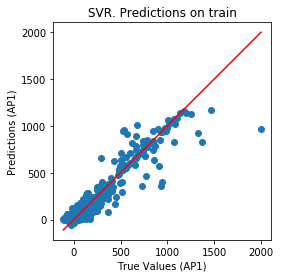

In [120]:
comparsion_plot(y_train, train_pred, data_type='train', current_target=current_target)

In [107]:
print_metrics(y_train, train_pred)

r: 0.953
MSE: 6891.792
R2: 0.908


## Test on test

In [108]:
predictions = svr.predict(X_st_test)

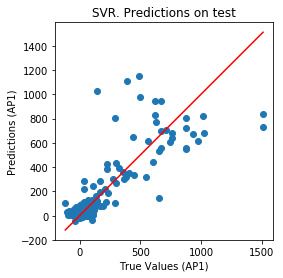

In [109]:
comparsion_plot(y_test, predictions, data_type='test', current_target=current_target)

In [110]:
print_metrics(y_test, predictions)

r: 0.838
MSE: 21147.515
R2: 0.692


In [ ]:
with open('SVR_model.cached', 'wb') as file:
    dill.dump(gs, file)

In [ ]:
with open('SVR_scalers.cached', 'wb') as file:
    dill.dump(st_scalers, file)

In [ ]:
dill.dump_session('Full_SVR.db')

In [ ]:
!jupyter nbconvert --to script SVR_full_script.ipynb